## Import delle librerie

In [1]:
!pip install datasets
!pip install evaluate
!pip install transformers
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.5 MB/s eta 0:0

In [2]:
import os
from google.colab import drive

import numpy as np
import pandas as pd

import datasets
import evaluate
import seaborn as sns

# Libreria transformers per utilizzare i Transformer models
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Librerie per le metriche
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr, pearsonr

## Caricamento dati da drive

In [49]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
data_folder = "/content/drive/MyDrive/accept/"

train_data = []
test_data = []

with open(data_folder + 'ACCEPT-Corpus-training.tsv', 'r') as f:
  next(f)
  for line in f:
    elements = line.rstrip('\n').split('\t')
    input_instance = {}
    input_instance["id"] = elements[0]
    input_instance["sentence"] = elements[5]
    input_instance["label"] = elements[2]
    train_data.append(input_instance)

with open(data_folder + 'acceptability-set-test.tsv', 'r') as f:
  next(f)
  for line in f:
    elements = line.rstrip('\n').split('\t')
    input_instance = {}
    input_instance["id"] = elements[0]
    input_instance["sentence"] = elements[5]
    input_instance["label"] = elements[2]
    test_data.append(input_instance)

In [51]:
# Conversione da lista di dizionari a dataset
train = datasets.Dataset.from_pandas(pd.DataFrame(data=train_data))
test = datasets.Dataset.from_pandas(pd.DataFrame(data=test_data))

# Splitting in train e dev del training set
#imposto seed=n per ottenere sempre lo stesso split
train_dev = train.train_test_split(test_size=0.1, shuffle=True, seed=42)

train = train_dev["train"]
dev = train_dev["test"]

# Stampo 'train' per vedere come è formattato
print(train)
print()
print("Esempio di testo:", train['sentence'][0])
print()
print("Esempio di score:", train['label'][0])
print()

# Shape dei dati di train, dev e test
print("Dimensione dei training, development and test sets:")
print("Train:", train.shape)
print("Dev:", dev.shape)
print("Test:", test.shape)

Dataset({
    features: ['id', 'sentence', 'label'],
    num_rows: 1205
})

Esempio di testo: Secondo te la documentazione del crimine sono le trascrizioni dell'intercettazi

Esempio di score: 4

Dimensione dei training, development and test sets:
Train: (1205, 3)
Dev: (134, 3)
Test: (344, 3)


## Caricamento modello e preprocessing

In [52]:
from transformers import set_seed
set_seed(12)

In [53]:
# Creo una variabile 'model' dove specificherò il modello da utilizzare
model_name = 'xlm-roberta-base'

# Carico il modello
# num_labels = 1 per specificare che si tratta di un task di regressione
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

# Carico il tokenizzatore
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

## **Preprocessing dei dati** ##

Dopo aver caricato i dati e memorizzati in *train*, *dev* e *test*, preprocessiamo il tutto, tokenizzando sia i testi che le label, trattandosi di un seq2seq model.

In [54]:
# Funzione che applica la tokenizzazione ai dati di training, dev e test
def tokenize(batch):
    tokens = tokenizer(batch['sentence'], padding=True, truncation=True, max_length=512)
    tokens['label'] = [float(label) for label in batch["label"]]

    return tokens

train = train.map(tokenize, batched=True)
dev = dev.map(tokenize, batched=True)
test = test.map(tokenize, batched=True)

train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
dev.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/1205 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/344 [00:00<?, ? examples/s]

## Addestramento del modello

### Training Arguments

In [55]:
# Trainer

num_epochs = 5

training_args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy = "epoch",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
)


### Metrica

In [56]:
def compute_metrics(eval_pred):
  spearman_metric = evaluate.load("spearmanr")
  predictions, label = eval_pred

  return spearman_metric.compute(predictions=predictions, references=label)

### Trainer

In [57]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train,
    eval_dataset=dev,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model("/content/drive/My Drive/FT-MODEL")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Spearmanr
1,5.163600,2.605917,0.539706
2,2.595800,1.706379,0.666639
3,2.020200,1.672983,0.759488
4,1.432400,0.939927,0.848005
5,0.887100,1.009601,0.864181


## **Evaluation del modello**

Dopo aver addestrato il modello, si passa alla fase di evaluation. Nello specifico, vogliamo:
- visualizzare l'andamento della loss sul dataset di training e di evaluation;
- calcolare le performance del modello sul dataset di test.

<Axes: xlabel='Epoch', ylabel='Loss'>

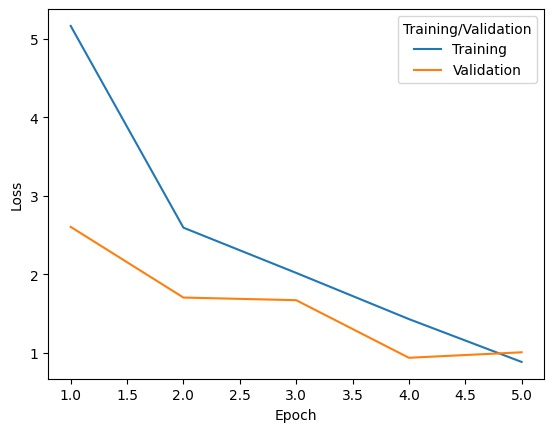

In [58]:
log_history = trainer.state.log_history

# Creo dataframe pandas per memorizzare le loss di training/evaluation e poi mostrare graficamente le curve
df = pd.DataFrame(columns=["Epoch", "Loss", "Training/Validation"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = pd.concat([df, pd.DataFrame.from_records([{"Epoch": epoch, "Loss": loss, "Training/Validation": "Training"}])], ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = pd.concat([df, pd.DataFrame.from_records([{"Epoch": epoch, "Loss": loss, "Training/Validation": "Validation"}])], ignore_index=True)
 
# Lineplot della loss
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Training/Validation")


In [60]:
df

,Epoch,Loss,Training/Validation
0,1,5.163600,Training
1,1,2.605917,Validation
2,2,2.595800,Training
3,2,1.706379,Validation
4,3,2.020200,Training
5,3,1.672983,Validation
6,4,1.432400,Training
7,4,0.939927,Validation
8,5,0.887100,Training
9,5,1.009601,Validation


### Calcolo performance sul testo set

In [61]:
output_predictions = trainer.predict(test)
output_predictions.predictions[:5]

array([[2.5986943],
       [5.672247 ],
       [6.8732333],
       [2.7432358],
       [5.6732535]], dtype=float32)

In [62]:
y_test = test["label"].tolist()
y_pred = output_predictions.predictions

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred) 
s, ps = spearmanr(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("Mean Absolute Error:", mae)
print("R2: ", r2)
print("Spearman (P-value):", s, "(", ps, ")")


Mean Squared Error:  1.0804984275699279
Mean Absolute Error: 0.7692001791194428
R2:  0.6227684848331365
Spearman (P-value): 0.7964923933865913 ( 1.0156273302282019e-76 )
